In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random

from time import time

from scipy.special import comb, loggamma, lambertw
from scipy.stats import multinomial, expon

from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf
import tensorflow_probability as tfp

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)

import os, shutil
from pathlib import Path
import json
import subprocess

from net_model import *
from custom_model import *
from mps_models import *

import mps
import pwexp

E0000 00:00:1742392412.284558 1104190 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742392412.287997 1104190 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1742392414.078634 1104190 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4203 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/natan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mri = np.load("OASIS - Small Dataset/mri_train_test.npz")
img_oasis = mri["images"]

# Basic functions to select the distribution and call the EM algorithm

In [3]:
def select_model(distribution, q):
    if(distribution == "poisson"):      
        log_a_str = log_a_poisson_str
        log_phi_str = log_phi_poisson_str
        C_str = C_poisson_str
        C_inv_str = C_inv_poisson_str
        sup_str = sup_poisson_str
        theta_min = None
        theta_max = None
    elif(distribution == "logarithmic"):
        log_a_str = log_a_log_str
        log_phi_str = log_phi_log_str
        C_str = C_log_str
        C_inv_str = C_inv_log_str
        sup_str = sup_log_str
        theta_min = 0
        theta_max = 1
    elif(distribution == "nb" or distribution == "mvnb"):
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_mvnb_str.format(q_argument)
        log_phi_str = log_phi_mvnb_str.format(q_argument)
        C_str = C_mvnb_str.format(q_argument)
        C_inv_str = C_inv_mvnb_str.format(q_argument)
        sup_str = sup_mvnb_str.format(q_argument)
        theta_min = None
        theta_max = None
    elif(distribution == "geometric"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(1, dtype = tf.float64)"
        log_a_str = log_a_mvnb_str.format(q_argument)
        log_phi_str = log_phi_mvnb_str.format(q_argument)
        C_str = C_mvnb_str.format(q_argument)
        C_inv_str = C_inv_mvnb_str.format(q_argument)
        sup_str = sup_mvnb_str.format(q_argument)
        theta_min = None
        theta_max = None
    elif(distribution == "bin" or distribution == "binomial"): 
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_bin_str.format(q_argument)
        log_phi_str = log_phi_bin_str.format(q_argument)
        C_str = C_bin_str.format(q_argument)
        C_inv_str = C_inv_bin_str.format(q_argument)
        sup_str = sup_bin_str.format(q_argument)
        theta_min = 0
        theta_max = 1
    elif(distribution == "bernoulli"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(1, dtype = tf.float64)"
        log_a_str = log_a_bin_str.format(q_argument)
        log_phi_str = log_phi_bin_str.format(q_argument)
        C_str = C_bin_str.format(q_argument)
        C_inv_str = C_inv_bin_str.format(q_argument)
        sup_str = sup_bin_str.format(q_argument)
        theta_min = 0
        theta_max = 1
    elif(distribution == "rgp"):
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_rgp_str.format(q_argument)
        log_phi_str = log_phi_rgp_str.format(q_argument)
        C_str = C_rgp_str.format(q_argument)
        C_inv_str = C_inv_rgp_str.format(q_argument)
        sup_str = sup_rgp_str.format(q_argument)
        theta_min = 0
        theta_max = np.abs(1/q)
    elif(distribution == "borel"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(1, dtype = tf.float64)"
        log_a_str = log_a_rgp_str.format(q_argument)
        log_phi_str = log_phi_rgp_str.format(q_argument)
        C_str = C_rgp_str.format(q_argument)
        C_inv_str = C_inv_rgp_str.format(q_argument)
        sup_str = sup_rgp_str.format(q_argument)
        theta_min = 0
        theta_max = 1
    elif(distribution == "geeta"):
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_geeta_str.format(q_argument)
        log_phi_str = log_phi_geeta_str.format(q_argument)
        C_str = C_geeta_str.format(q_argument)
        C_inv_str = C_inv_geeta_str.format(q_argument)
        sup_str = sup_geeta_str.format(q_argument)
        theta_min = 0
        theta_max = np.abs(1/q)
    elif(distribution == "haight"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(2, dtype = tf.float64)"
        log_a_str = log_a_geeta_str.format(q_argument)
        log_phi_str = log_phi_geeta_str.format(q_argument)
        C_str = C_geeta_str.format(q_argument)
        C_inv_str = C_inv_geeta_str.format(q_argument)
        sup_str = sup_geeta_str.format(q_argument)
        theta_min = 0
        theta_max = 1/2

    return log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max

def fit_cure_model(distribution, q,
                   t_train, t_val,
                   delta_train, delta_val,
                   img_train, img_val,
                   max_iterations = 100,
                   early_stopping_em = True, early_stopping_em_warmup = 5, early_stopping_em_eps = 1.0e-6,
                   epochs = 100, batch_size = None, shuffle = True,
                   learning_rate = 0.001, run_eagerly = False, gradient_accumulation_steps = None,
                   early_stopping_nn = True, early_stopping_min_delta_nn = 0.0, early_stopping_patience_nn = 5,
                   reduce_lr = True, reduce_lr_steps = 10, reduce_lr_factor = 0.1,
                   verbose = 1, seed = 1):
    alpha0, s_t = initialize_alpha_s(t_train, delta_train, n_cuts = 5)

    # Select the MPS functions based on the chosen distribution
    log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max = select_model(distribution, q)

    set_all_seeds(seed)
    # Because it only serves to initialize the model weights, the distribution does not matter in this case (that's why we use the Poisson here)
    dummy_mps_model = MPScrModel(log_a_poisson_tf, log_phi_poisson_tf, C_poisson_tf, C_inv_poisson_tf, sup_poisson)
    dummy_mps_model.define_structure(shape_input = img_train[0].shape, seed = seed)

    # If batch_size is None, use just one big batch
    if(batch_size is None):
        batch_size = len(t_train)
    else:
        if(gradient_accumulation_steps is None):
            # If batch_size is not None, modify the gradient accumulation steps in order for the model
            # to update the wegihts a single time each epoch. That is crucial to reduce batch noises, as we are
            # trying to minimize a custom loss function based on the likelihood
            n_train = len(t_train)
            n_batches = int( np.ceil(n_train / batch_size) )
            gradient_accumulation_steps = n_batches
        
    results = call_EM("EM.py",
                      log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max,
                      dummy_mps_model, alpha0, s_t,
                      img_train, t_train, delta_train, delta_train,
                      max_iterations = max_iterations,
                      early_stopping_em = early_stopping_em, early_stopping_em_warmup = early_stopping_em_warmup, early_stopping_em_eps = early_stopping_em_eps,
                      epochs = epochs, batch_size = batch_size, shuffle = shuffle,
                      learning_rate = learning_rate, run_eagerly = run_eagerly, gradient_accumulation_steps = gradient_accumulation_steps,
                      early_stopping_nn = early_stopping_nn, early_stopping_min_delta_nn = early_stopping_min_delta_nn, early_stopping_patience_nn = early_stopping_patience_nn,
                      reduce_lr = reduce_lr, reduce_lr_steps = reduce_lr_steps, reduce_lr_factor = reduce_lr_factor,
                      validation = True,
                      x_val = img_val, t_val = t_val, delta_val = delta_val, m_val = delta_val,
                      verbose = verbose, seed = seed, alpha_known = False)
    results["s_t"] = s_t
    
    return results

In [4]:
print("Creating directories structure")
dists = ["poisson", "logarithmic", "geometric", "mvnb", "bernoulli", "bin", "rgp", "borel", "rgp", "haight", "geeta"]
for dist in dists:
    for j in range(1,101):
        Path("OASIS - Results/{}/{}".format(dist,j)).mkdir(parents=True, exist_ok=True)

Creating directories structure


In [5]:
def run_bootstrap_distribution_oasis(distribution, q, images, start_index = 1, seed = 10):

    metadata_filename = "OASIS - Results/{}/sim_metadata.csv".format(distribution)
    # If metadata file exists, load it. If not, just initialize the metadata lists as empty
    if( os.path.isfile(metadata_filename) ):
        sim_metadata = pd.read_csv(metadata_filename)
        # If start_index is less than the size of metadata, there might be an error on the call of this function
        # It alerts that some information may be overwritten
        if(start_index is None):
            start_index = sim_metadata.shape[0]+1
        elif(start_index < sim_metadata.shape[0]):
            raise Exception("start_index is less than previously executed registers.")
            
        execution_times = sim_metadata["execution_times"].to_list()
        loss_values = sim_metadata["loss_values"].to_list()
        loss_val_values = sim_metadata["loss_val_values"].to_list()
        converged = sim_metadata["converged"].to_list()
        steps = sim_metadata["steps"].to_list()
    else:
        execution_times = []
        loss_values = []
        loss_val_values = []
        converged = []
        steps = []
    
    for i in tqdm(range(start_index, 101)):
        df_sample = pd.read_csv("OASIS - Small Dataset/bootstrap_sample/sample_{}.csv".format(i))

        df_train = df_sample.loc[df_sample["set"] == "train", :]
        df_val = df_sample.loc[df_sample["set"] == "val", :]
        
        t_train = df_train["time"]
        delta_train = df_train["delta"]
        img_train = images[ df_train["image_index"] ]
        t_val = df_val["time"]
        delta_val = df_val["delta"]
        img_val = images[ df_val["image_index"] ]

        start_time = time()
        result = fit_cure_model(distribution, q,
                                t_train, t_val,
                                delta_train, delta_val,
                                img_train, img_val,
                                batch_size = 64, max_iterations = 60, early_stopping_em_eps = 1.0e-6,
                                early_stopping_em_warmup = 10,
                                learning_rate = 0.001, early_stopping_patience_nn = 10,
                                reduce_lr = True, reduce_lr_steps = 12, reduce_lr_factor = 0.1,                                
                                seed = seed, verbose = 0)
        elapsed_time = time() - start_time
        execution_times.append(elapsed_time)
        # Save the model weights
        result["new_model"].save_model("OASIS - Results/{}/{}/model.weights.h5".format(distribution, i))

        # Save the piecewise exponential estimated parameters
        save_alpha_s(result["new_alpha"], result["s_t"], filename = "OASIS - Results/{}/{}/alpha_s.csv".format(distribution, i))

        loss_values.append( result["loss_history"][-1] )
        loss_val_values.append( result["loss_val_history"][-1] )
        converged.append( result["converged"] )
        steps.append( result["steps"] )

        pd.DataFrame({"execution_times": execution_times, "loss_values": loss_values, "loss_val_values": loss_val_values, "converged": converged, "steps": steps}).to_csv(
            "OASIS - Results/{}/sim_metadata.csv".format(distribution), index = False
        )

In [6]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def ROC_real(cured, pred_p):
    fpr, tpr, thresholds = roc_curve(cured, pred_p, drop_intermediate = False)
    return fpr, tpr, thresholds

def AUC_real(cured, pred_p):
    fpr, tpr, thresholds = ROC_real(cured, pred_p)
    return auc(fpr, tpr)

def ROC_estimated(pred_p):
    thresholds = np.unique(pred_p)
    # Reshape the cure_probs array for broadcasting
    pred_p = np.reshape(pred_p, (len(pred_p), 1))
    tpr = np.sum( (pred_p < thresholds) * (1-pred_p), axis = 0 ) / np.sum( 1-pred_p )
    fpr = np.sum( (pred_p < thresholds) * pred_p, axis = 0 ) / np.sum( pred_p )
    return fpr, tpr, thresholds

def AUC_estimated(pred_p):
    fpr, tpr, thresholds = ROC_estimated(pred_p)
    return auc(fpr, tpr)

In [7]:
i = 3
distribution = "poisson"
q = None

df_sample = pd.read_csv("OASIS - Small Dataset/bootstrap_sample/sample_{}.csv".format(i))

df_train = df_sample.loc[df_sample["set"] == "train", :]
df_val = df_sample.loc[df_sample["set"] == "val", :]
t_train = df_train["time"]
delta_train = df_train["delta"]
img_train = img_oasis[ df_train["image_index"] ]
t_val = df_val["time"]
delta_val = df_val["delta"]
img_val = img_oasis[ df_val["image_index"] ]

start_time = time()
result = fit_cure_model(distribution, q,
                        t_train, t_val,
                        delta_train, delta_val,
                        img_train, img_val,
                        batch_size = 64, max_iterations = 60, early_stopping_em_eps = 1.0e-6,
                        early_stopping_em_warmup = 10,
                        learning_rate = 0.001, early_stopping_patience_nn = 10,
                        reduce_lr = True, reduce_lr_steps = 12, reduce_lr_factor = 0.1,                                
                        seed = 10, verbose = 1)
elapsed_time = time() - start_time

I0000 00:00:1742227476.449562  418836 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2812 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
E0000 00:00:1742227477.677252  418954 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742227477.680765  418954 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1742227479.935341  418954 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2690 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1742227480.033661  418954 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2690 MB memory:  -> devi

Algoritmo convergiu após 36 iterações. Retornando.
Número de arquivos no diretório: 36


In [10]:
AUC_train = AUC_estimated( pred_p[df_sample["set"] == "train"] )

I0000 00:00:1742227741.410099  418924 cuda_dnn.cc:529] Loaded cuDNN version 90300


0.9443146759413897


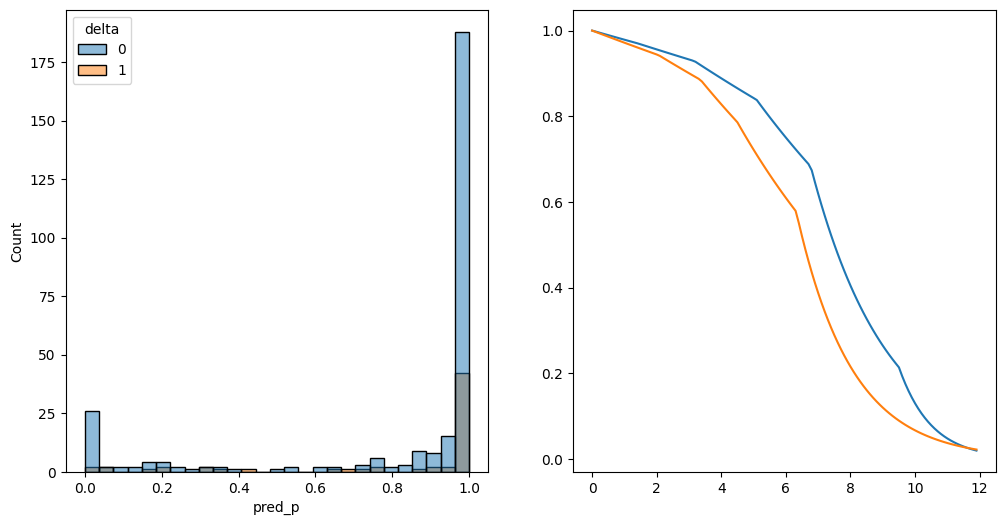

In [9]:
pred_eta = result["new_model"].predict(img_oasis, verbose = 0)
pred_p = result["new_model"].link_func( pred_eta ).numpy().flatten()
pred_m = update_m_mps(result["new_model"], result["new_alpha"], result["s_t"], img_oasis, df_sample["time"].to_numpy().flatten(), df_sample["delta"].to_numpy().flatten())

df_results = pd.DataFrame({"t": df_sample["time"], "delta": df_sample["delta"], "pred_p": pred_p, "set": df_sample["set"]})
AUC_test = AUC_estimated( df_results.loc[df_results["set"] == "test", "pred_p"].to_numpy().flatten() )
print(AUC_test)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

sns.histplot(x = "pred_p", hue = "delta", data = df_results, ax = ax[0])

tv = np.arange(0, 12, 0.1)
S1_tv = S1(tv, result["new_alpha"], result["s_t"])

s_t_xie = np.array([0, 2.062, 3.36, 4.495, 6.32, 12.2])
alpha_xie = np.array([0.02872308, 0.04870019, 0.10390695, 0.16946955, 0.5868493 , 1])
S1_tv_xie = S1(tv, alpha_xie, s_t_xie)

ax[1].plot(tv, S1_tv)
ax[1].plot(tv, S1_tv_xie)

plt.show()

In [11]:
np.round(pred_m, 2)[pred_m > 1]

array([ 1.  ,  1.41,  1.08,  1.  ,  1.  ,  4.21,  2.01,  1.94,  1.12,
        1.  ,  1.01,  1.37,  1.  ,  1.3 ,  3.05,  5.44,  1.  ,  1.  ,
        1.06,  5.7 ,  1.68, 10.83,  5.25,  1.02,  3.69,  1.68,  7.21,
        1.  ,  2.89,  1.  ,  1.01,  1.  ,  1.01,  1.  ,  1.  ,  1.  ,
        1.  ,  1.  ,  1.  ,  4.9 ,  1.44, 10.11,  1.17,  5.63,  1.  ,
        1.09,  6.85,  1.59,  2.42,  1.  ,  7.81,  1.32,  1.91,  1.45,
        1.  ,  1.  ,  1.07,  1.01,  1.03,  1.84,  7.53,  1.  ,  4.38,
        1.  ,  1.  ,  1.  ,  3.24,  2.  ,  1.  ,  3.18,  1.06,  1.  ,
        1.28,  1.  ,  1.35,  2.07,  1.  ,  1.  ,  1.  ,  1.24,  2.7 ,
        1.6 ,  1.  ,  1.  ,  1.02,  2.23,  1.  ,  1.36, 10.13,  1.22,
        1.01,  2.55,  1.53,  1.  ])

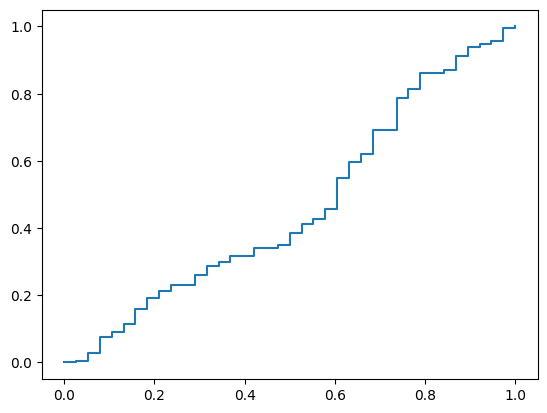

In [42]:
pred_p = result["new_model"].link_func( pred_eta ).numpy().flatten()
pred_p_train = pred_p[df_sample["set"] == "train"]
delta_train = df_sample.loc[df_sample["set"] == "train", "delta"]
censor_occurred_train = 1-delta_train

fpr, tpr, thresholds = roc_curve(censor_occurred_train, pred_p_train)
plt.plot(fpr, tpr)

In [8]:
np.mean( (result["new_model"].link_func( result["new_model"].predict(img_oasis, verbose = False).flatten() ) < 0.2) &
         (df_sample["delta"] == 1) )

np.float64(0.011363636363636364)

In [11]:
result["new_model"].link_func( result["new_model"].predict(img_oasis, verbose = False).flatten() )[:20]

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([0.85413119, 0.8863197 , 0.95830615, 0.95314763, 0.99662328,
       0.87339422, 0.94912961, 0.92882571, 0.91138861, 0.60049317,
       0.1600187 , 0.96965057, 0.78562027, 0.79549012, 0.88699537,
       0.94719725, 0.97197448, 0.95577613, 0.68993525, 0.93689823])>

In [11]:
df_sample["delta"].to_numpy()[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
tv = np.arange()

# Distributions with a single parameter, $\theta$

In the following cells, we fit the MPScr-NN model to all 100 bootstrap samples considering the distributions that are uniparametric, i.e. does not depend on the extra parameter, q. Those are:
* Poisson
* Logarithmic
* Geometric
* Bernoulli
* Borel
* Haight

In [5]:
mri = np.load("OASIS - Small Dataset/mri_train_test.npz")
img_oasis = mri["images"]
run_bootstrap_distribution_oasis("poisson", None, img_oasis, start_index = 1, seed = 10)

I0000 00:00:1742154955.228112  269838 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4118 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [4:43:02<00:00, 169.83s/it]


In [54]:
mri = np.load("OASIS - Small Dataset/mri_train_test.npz")
img_oasis = mri["images"]
# The seed used was 10, but for the first dataset (i = 1) we used seed = 1
# (the model was resulting in a constant prediction, possibily did not converge properly)
run_bootstrap_distribution_oasis("geometric", None, img_oasis, start_index = None, seed = 10)

 27%|█████████████████████████████████████████████▌                                                                                                                         | 6/22 [20:21<54:17, 203.62s/it]

KeyboardInterrupt



In [ ]:
mri = np.load("OASIS - Small Dataset/mri_train_test.npz")
img_oasis = mri["images"]
run_bootstrap_distribution_oasis("bernoulli", None, img_oasis, start_index = 1, seed = 1)

In [ ]:
mri = np.load("OASIS - Small Dataset/mri_train_test.npz")
img_oasis = mri["images"]
run_bootstrap_distribution_oasis("logarithmic", None, img_oasis, start_index = 1, seed = 1)

In [7]:
mri = np.load("OASIS - Small Dataset/mri_train_test.npz")
img_oasis = mri["images"]
run_bootstrap_distribution_oasis("borel", None, img_oasis, start_index = 1, seed = 10)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [4:07:42<00:00, 148.63s/it]


In [6]:
mri = np.load("OASIS - Small Dataset/mri_train_test.npz")
img_oasis = mri["images"]
run_bootstrap_distribution_oasis("haight", None, img_oasis, start_index = 1, seed = 10)

I0000 00:00:1742175268.109259 1433195 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4118 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [4:17:06<00:00, 154.27s/it]
